# CO416 - Machine Learning for Imaging

## Tutorial 6 - Unsupervised learning

### Data and imports

In [1]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline

data_dir = "/home/vigilante/unsupervised/"
print(os.listdir(data_dir))

['ct-brain-lesion.nii.gz', 'mri-brain-mask.nii.gz', 'mri-brain-tissues.nii.gz', 'mri-brain.nii.gz', 'spine-data.txt', 'ct-brain.nii.gz', 'ct-brain-mask.nii.gz']


### Set up the image viewer

In [2]:
from ipywidgets import interact, fixed
from IPython.display import display
from utils.image_viewer import display_image

### Image segmentation via clustering

We can segment an image into consistent regions using unsupervised clustering techniques. This is different to semantic segmentation, as in clustering a segmented region does not have necessarily have a semantic meaning. However, clustering can still be useful as sometimes it is relatively easy to infer which region corresponds to which anatomical structure, as we will see.

Let us start by loading an MRI brain scan `"mri-brain.nii.gz"`. For this scan, we already obtained a brain mask using a neuroimaging toolkit which allows us to mask out non-brain structures.

MR image


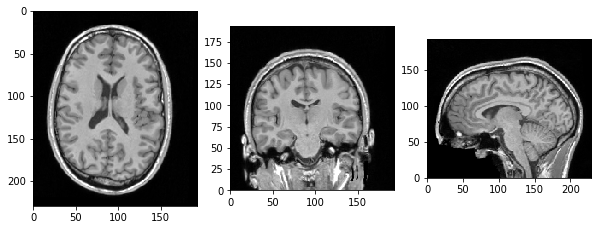

Brain mask


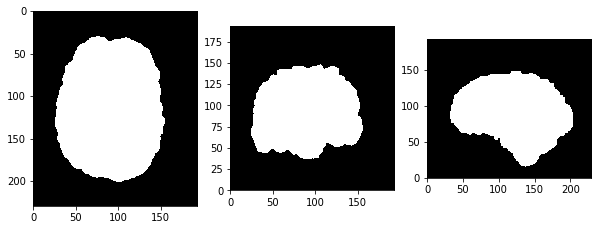

In [3]:
img = sitk.ReadImage(data_dir + 'mri-brain.nii.gz')
msk = sitk.ReadImage(data_dir + 'mri-brain-mask.nii.gz')
print('MR image')
display_image(img, window=400, level=200)
print('Brain mask')
display_image(msk)

We use the brain mask to mask out non-brain regions by setting them to zero

Masked image


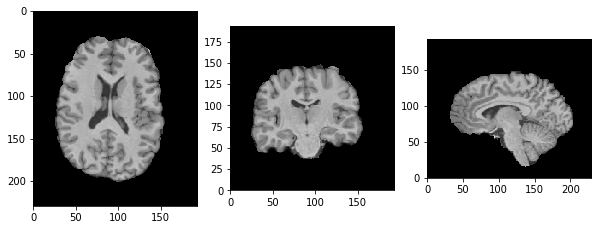

In [4]:
img_array = sitk.GetArrayFromImage(img)
msk_array = sitk.GetArrayFromImage(msk)

masked_array = img_array
masked_array[msk_array==0] = 0

img_masked = sitk.GetImageFromArray(masked_array)
img_masked.CopyInformation(img)

print('Masked image')
display_image(img_masked, window=400, level=200)

#### Data preparation for clustering

We want to run different clustering methods on the masked brain data. As the clustering techniques we will be using don't take any spatial information into account, we can simply flatten the 3D imaging data into one big 1D vector $X$.

Let's visualise the data by plotting a normalised histogram.

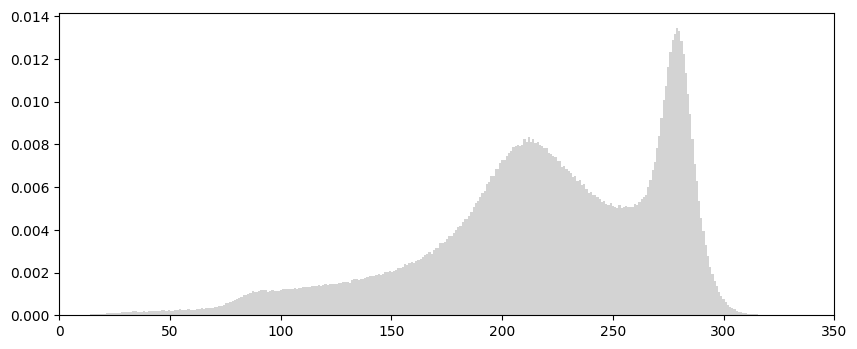

Number of points 1418157


In [5]:
# Take all non-zero voxels and flatten the data into a 1D numpy array
X = img_array[msk_array > 0].flatten().reshape(-1, 1)

# Get the number of points
num_pts = len(X.flatten())

# Extract the minimum and maximum intensity values and calculate the number of bins for the histogram
lim_low = np.min(X).astype(np.int)
lim_high = np.max(X).astype(np.int)
num_bins = (lim_high - lim_low + 1)

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X, bins=num_bins, density=True, range=(lim_low, lim_high), color='lightgray');
plt.xlim([0,350]); # we limit the x-axis to the range of interest
plt.show()

print('Number of points ' + str(num_pts))

#### Random subsampling

We have about 1.4 million data points, which can make clustering computationally inefficient. A common strategy in these cases is to use a random subset of the original data.

For example, we can randomly subsample the data with a given percentage, say 5%. The histogram is a bit noisier, but preserves the overall shape.

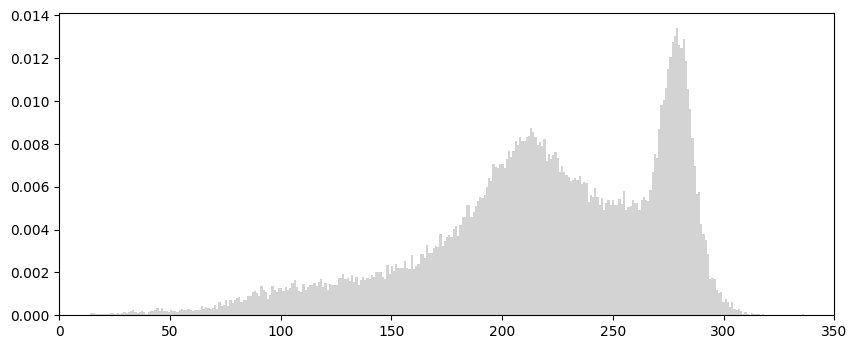

Number of points 70907


In [6]:
sampling = 0.05
X_subset = np.random.choice(X.flatten(),int(num_pts*sampling)).reshape(-1, 1)

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X_subset, bins=num_bins, density=True, range=(lim_low, lim_high), color='lightgray');
plt.xlim([0,350]);
plt.show()

print('Number of points ' + str(len(X_subset)))

#### How many clusters do we want?

That's the key question when applying clustering techniques. Sometimes we have a good idea about the number of clusters that we would like our data to be partitioned into. Sometimes we don't, and finding out the number of clusters is part of data exploration in unsupervised learning.

For now, let's assume we know that our brain consists of mostly three tissue types, grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). So we set the number of clusters to three.

In [7]:
num_clusters = 3

#### K-means

Let's start with one of the most popular and well known clustering techniques, k-means (as discussed in the lecture). `scikit-learn` provides us with an efficient implementation.

**Task:** Go through the steps below, and try to understand what's happening in each step. You might want to check out the scikit-learn's [overview of clustering](http://scikit-learn.org/stable/modules/clustering.html) and the [k-means documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

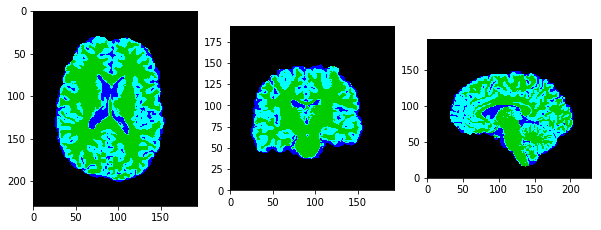

In [8]:
import sklearn.cluster as cluster

# Create a k-means instance
kmeans = cluster.KMeans(n_clusters=num_clusters)

# Running k-means via the fit function
kmeans.fit(X_subset)

# Produce the clustering result for all image points
y = kmeans.predict(img_array.flatten().reshape(-1, 1))

# K-means will produce labels between 0 and (k-1), we want 0 to be background, so we shift the labels by one
y = y + 1 # shift labels
y[(msk_array == 0).flatten()] = 0 # zero background

# Construct a 3D label map
lab_array = y.reshape(img_array.shape).astype('uint8')
seg_kmeans = sitk.GetImageFromArray(lab_array)
seg_kmeans.CopyInformation(img)

# Display the results using SimpleITK mapping of label maps to colours
display_image(sitk.LabelToRGB(seg_kmeans))

#### Gaussian Mixture Models

There are many other clustering tecniques we can apply, and `scikit-learn` makes it very easy to swap between methods as they have a common interface based on `fit` and `predict` functions.

**Task:** Try out the [GaussianMixture](http://scikit-learn.org/stable/modules/mixture.html#mixture) which we discussed in the lecture (slides 18 and following).

Covariance type spherical


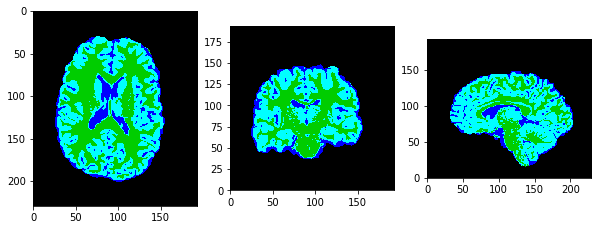

Covariance type diag


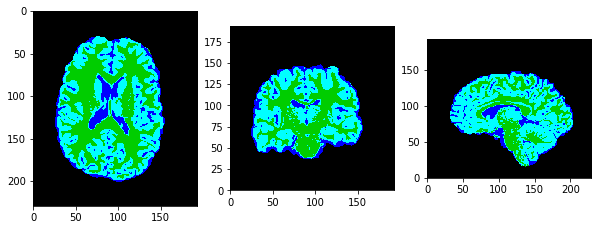

Covariance type tied


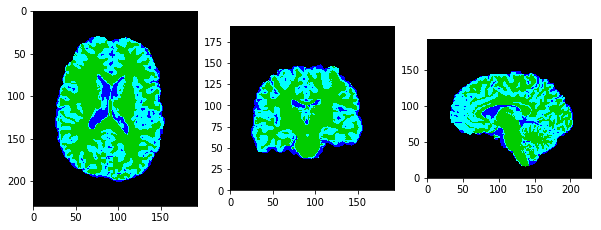

Covariance type full


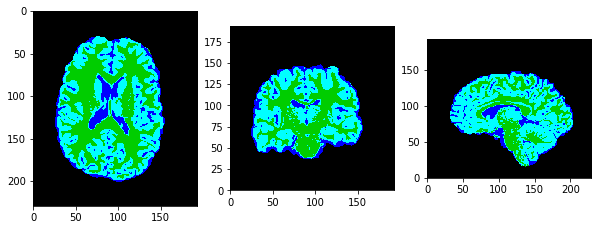

In [26]:
import sklearn.mixture as mixture

def plot_gmm(num_clusters, cov_type):
    # Create a GaussianMixture instance
    gmm = mixture.GaussianMixture(n_components=num_clusters, covariance_type=cov_type, random_state=0).fit(X_subset)

    y = gmm.predict(img_array.flatten().reshape(-1, 1))

    # K-means will produce labels between 0 and (k-1), we want 0 to be background, so we shift the labels by one
    y = y + 1 # shift labels
    y[(msk_array == 0).flatten()] = 0 # zero background

    # Construct a 3D label map
    lab_array = y.reshape(img_array.shape).astype('uint8')
    seg_gmm = sitk.GetImageFromArray(lab_array)
    seg_gmm.CopyInformation(img)

    # Display the results using SimpleITK mapping of label maps to colours
    display_image(sitk.LabelToRGB(seg_gmm))
    
for cov_type in ['spherical', 'diag', 'tied', 'full']:
    print("Covariance type " + cov_type)
    plot_gmm(num_clusters, cov_type)

#### Plotting the GMM result

The cell below will plot the GMM on top of the image histogram, similar to what you saw in the lecture.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


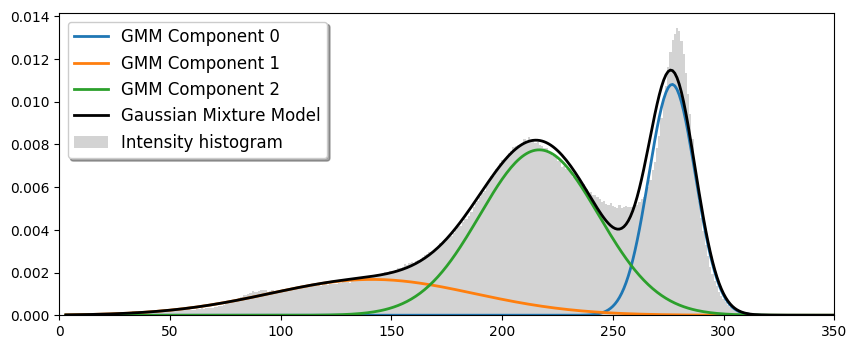

In [23]:
import matplotlib.mlab as mlab

def plot_gmm(x, gmm):
    omega = gmm.weights_
    mu = gmm.means_
    sigma = np.sqrt(gmm.covariances_)
    for ind in range(0,omega.shape[0]): 
        plt.plot(x,omega[ind]*mlab.normpdf(x, mu[ind], sigma[ind]), linewidth=2, label='GMM Component '+str(ind))

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X, bins=num_bins, density=True, range=(lim_low, lim_high), label='Intensity histogram', color='lightgray');
x = np.linspace(lim_low,lim_high,num_bins).reshape(-1,1)
plot_gmm(x,gmm)
plt.plot(x,np.exp(gmm.score_samples(x)), linewidth=2, color='k', label='Gaussian Mixture Model')
plt.xlim([0,350])
plt.legend(loc=0, shadow=True, fontsize=12)

#### Other clustering methods

**Optional Task:** Try out other [clustering methods](http://scikit-learn.org/stable/modules/clustering.html#clustering). For example, you can try out [BayesianGaussianMixture](http://scikit-learn.org/stable/modules/mixture.html#variational-bayesian-gaussian-mixture). You can also re-use the GMM plotting code from above to plot the results of the Bayesian GMM fitting.

#### Evaluation

For the MRI brain scan, we also have some reference segmentation of GM, WM, and CSF.

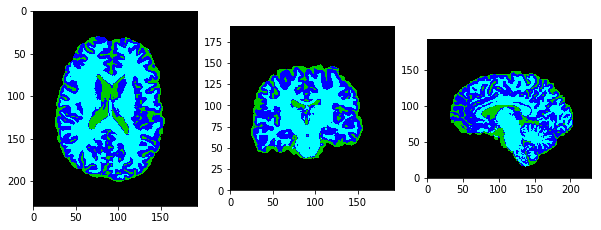

In [20]:
ref = sitk.ReadImage(data_dir + 'mri-brain-tissues.nii.gz')
display_image(sitk.LabelToRGB(ref))

**Task (a):** Devise a heuristic which allows you to identify which of the clusters obtained with a clustering method (e.g., k-means or GMMs) corresponds to which tissue class. In the reference segmentation we have labels as CSF=1, GM=2, and WM=3.

**Task (b):** Using your heuristic, calculate the Dice Similarity Coefficients (DSC) for CSF, GM, and WM when comparing the clustering results to the reference segmentation. See the MLI-MIC-Summary notebook from the second coursework for how to compute DSC using SimpleITK.

### Lesion segmentation using clustering

**Optional task:** Try out the above clustering methods with **different numbers of clusters** on the provided `"ct-brain.nii.gz"` image.

In [ ]:
img = sitk.ReadImage(data_dir + 'ct-brain.nii.gz')
msk = sitk.ReadImage(data_dir + 'ct-brain-mask.nii.gz')

print('CT image')
display_image(img, x=70, y=100, z=90, window=120, level=40)

print('Brain mask')
display_image(msk, x=70, y=100, z=90)

In [ ]:
img_array = sitk.GetArrayFromImage(img)
msk_array = sitk.GetArrayFromImage(msk)

masked_array = img_array
masked_array[msk_array==0] = 0

img_masked = sitk.GetImageFromArray(masked_array)
img_masked.CopyInformation(img)

print('Masked image')
display_image(img_masked, x=70, y=100, z=90, window=120, level=40)

In [ ]:
# Take all non-zero voxels and flatten the data into a 1D numpy array
X = img_array[msk_array > 0].flatten().reshape(-1, 1)

# Get the number of points
num_pts = len(X.flatten())

# Extract the minimum and maximum intensity values and calculate the number of bins for the histogram
lim_low = -20 # manually set intensity range of interest
lim_high = 100 # manually set intensity range of interest
num_bins = (lim_high - lim_low + 1)

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X, bins=num_bins, density=True, range=(lim_low,lim_high), color='lightgray');
plt.xlim([0,80]) # we limit the x-axis to the range of interest
plt.show()

print('Number of points ' + str(num_pts))

In [ ]:
sampling = 0.05
X_subset = np.random.choice(X.flatten(),int(num_pts*sampling)).reshape(-1, 1)

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X_subset, bins=num_bins, density=True, range=(lim_low, lim_high), color='lightgray');
plt.xlim([0,80]);
plt.show()

print('Number of points ' + str(len(X_subset)))

In [ ]:
num_clusters = 5

In [ ]:
import sklearn.cluster as cluster

# Create a k-means instance
kmeans = cluster.KMeans(n_clusters=num_clusters)

# Running k-means via the fit function
kmeans.fit(X_subset)

# Produce the clustering result for all image points
y = kmeans.predict(img_array.flatten().reshape(-1, 1))

# K-means will produce labels between 0 and (k-1), we want 0 to be background, so we shift the labels by one
y = y + 1 # shift labels
y[(msk_array == 0).flatten()] = 0 # zero background

# Construct a 3D label map
lab_array = y.reshape(img_array.shape).astype('uint8')
seg_kmeans = sitk.GetImageFromArray(lab_array)
seg_kmeans.CopyInformation(img)

# Display the results using SimpleITK mapping of label maps to colours
display_image(sitk.LabelToRGB(seg_kmeans))

### Principal Component Analysis

As discussed in the unsupervised learning lecture, Principal Component Analysis (PCA) allows us to do dimensionality reduction and construct statistical models. The idea here is to use PCA to find the principal modes (or components) of largest variation in the data.

This is illustrated below with a simple 2D toy example, similar to the one in the lecture slides.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# generate 2D toy data, 1000 samples
m = 1000
x = np.random.normal(5,2,m)
y = 2*x + np.random.normal(0,3,m)

plt.figure(figsize=(7, 7), dpi=100)
plt.scatter(x,y,marker='.')
plt.xlim([-10,20])
plt.ylim([-5,25])
plt.axis('equal');

#### Running PCA

We now perform the steps of PCA as outlined in the lecture.

**Step 1:** Put the data together in one big matrix $X$

In [ ]:
X = np.vstack((x,y))
n, m = X.shape
print('Dimension:\t' + str(n))
print('Samples:\t' + str(m))

**Step 2:** Normalise the data

In [ ]:
mu_X = np.mean(X, axis=1)
X_prime = (1 / np.sqrt(m-1)) * (X - np.tile(mu_X, (m, 1)).T)

**Step 3:** Run singular value decomposition (SVD)

In [ ]:
U, D, V = np.linalg.svd(np.matmul(X_prime,X_prime.T))

We plot the results by overlaying the principal components (directions of largest variations) with three times the standard deviation (capturing 99.7% of values around the mean of a normal distribution, see also [68–95–99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

In [ ]:
# first principal component
p1a = mu_X + U[:,0] * np.sqrt(D[0])*3;
p1b = mu_X - U[:,0] * np.sqrt(D[0])*3;

# second principal component
p2a = mu_X + U[:,1] * np.sqrt(D[1])*3;
p2b = mu_X - U[:,1] * np.sqrt(D[1])*3;

plt.figure(figsize=(7, 7), dpi=100)
plt.scatter(X[0,:],X[1,:],marker='.', color='lightgray')
plt.plot((p1a[0],p1b[0]),(p1a[1],p1b[1]), linewidth=3)
plt.plot((p2a[0],p2b[0]),(p2a[1],p2b[1]), linewidth=3)
plt.xlim([-10,20])
plt.ylim([-5,25])
plt.axis('equal');

We can confirm the Gaussian nature of PCA by overlaying a contour plot generating from a multivariate 

In [ ]:
from scipy.stats import multivariate_normal
covar = np.matmul(X_prime,X_prime.T)
gauss_2d = multivariate_normal(mu_X, covar)

i, j = np.mgrid[-10:20:.01, -5:25:.01]
pos = np.empty(i.shape + (2,))
pos[:, :, 0] = i; pos[:, :, 1] = j

plt.figure(figsize=(7, 7), dpi=100)
plt.scatter(X[0,:],X[1,:],marker='.', color='lightgray')
plt.plot((p1a[0],p1b[0]),(p1a[1],p1b[1]), linewidth=3)
plt.plot((p2a[0],p2b[0]),(p2a[1],p2b[1]), linewidth=3)
plt.contour(i, j, gauss_2d.pdf(pos), cmap='viridis')
plt.xlim([-10,20])
plt.ylim([-5,25])
plt.axis('equal');

#### Running PCA using scikit-learn

We can also utilise the [PCA implementation](http://scikit-learn.org/stable/modules/decomposition.html#pca) of scikit-learn which is easier than doing it manually as above. It also has some additional features such as whitening.

In [ ]:
import sklearn.decomposition as decomp

# Create PCA instance
pca = decomp.PCA()

# Fit the data
pca.fit(X.T)

Let's confirm that we get the same results. Note, scikit-learn's PCA will gives us the singular values which can be converted to eigenvalues $\lambda_i=s_i^2 \, / \, (m-1)$.

In [ ]:
# Get the mean from PCA
mu_X = pca.mean_

# Get principal modes (a.k.a. components) from PCA
U = pca.components_.T

# Get the eigenvalues from PCA's singular values
D = pca.singular_values_**2 / (m - 1)

gauss_2d = multivariate_normal(mu_X, pca.get_covariance())

# first principal component
p1a = mu_X + U[:,0] * np.sqrt(D[0])*3;
p1b = mu_X - U[:,0] * np.sqrt(D[0])*3;

# second principal component
p2a = mu_X + U[:,1] * np.sqrt(D[1])*3;
p2b = mu_X - U[:,1] * np.sqrt(D[1])*3;

plt.figure(figsize=(7, 7), dpi=100)
plt.scatter(X[0,:],X[1,:],marker='.', color='lightgray')
plt.plot((p1a[0],p1b[0]),(p1a[1],p1b[1]), linewidth=3)
plt.plot((p2a[0],p2b[0]),(p2a[1],p2b[1]), linewidth=3)
plt.contour(i, j, gauss_2d.pdf(pos), cmap='viridis')
plt.xlim([-10,20])
plt.ylim([-5,25])
plt.axis('equal');

### PCA Shape Models of the Spine

Now, let's use PCA to construct a statistical shape model of the spine.

We load the spine data consisting of 200 examples of 26 3D coordinates corresponding to the centroids of the vertebral bodies.

In [ ]:
import numpy as np

spine_data = np.genfromtxt('/vol/lab/course/416/data/unsupervised/spine-data.txt')
n, m = spine_data.shape

# the data is stored as a one 78x200 matrix
# for visualisation purposes we split the data
# into three sets of x, y, and z coordinates
num_centroids = n//3;
x_ind = range(num_centroids)
y_ind = range(num_centroids,num_centroids*2)
z_ind = range(num_centroids*2,num_centroids*3)

cx = spine_data[x_ind,:];
cy = spine_data[y_ind,:];
cz = spine_data[z_ind,:];

print('Dimension:\t' + str(n))
print('Samples:\t' + str(m))

Let's visualise the raw input data

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

def plot_spines(x,y,z,max_range=None,marker_size=10,figure_size=5):

    fig = plt.figure(figsize=(figure_size, figure_size), dpi=100)
    ax = fig.gca(projection='3d')
    for s in range(x.shape[1]):
        ax.scatter(x[:,s], y[:,s], z[:,s], s=marker_size, marker='.')
        ax.plot(x[:,s], y[:,s], z[:,s])

    if max_range == None:
        max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.view_init(5,45)
    ax.grid()
    
plot_spines(cx, cy, cz)

We notice, the data is all over the place which is normal as the raw coordinates extracted from the original CT images are not in the same coordinate space. Let's spatially normalise the data a bit by centering all spine at their geometric mean.

In [ ]:
# spatial normalisation
cx_norm = cx - np.tile(np.mean(cx,axis=0),(num_centroids,1))
cy_norm = cy - np.tile(np.mean(cy,axis=0),(num_centroids,1))
cz_norm = cz - np.tile(np.mean(cz,axis=0),(num_centroids,1))

plot_spines(cx_norm, cy_norm, cz_norm)

Let's have a look how the average human spine looks like

In [ ]:
cx_mean = np.mean(cx_norm,axis=1)
cy_mean = np.mean(cy_norm,axis=1)
cz_mean = np.mean(cz_norm,axis=1)

plot_spines(cx_mean.reshape(-1,1), cy_mean.reshape(-1,1), cz_mean.reshape(-1,1), marker_size=100)

#### Running PCA

**Task:** Use scikit-learn's implementation to perform PCA on the normalised spine data. Make sure to assign the following variables correctly: `mu_X` (mean), `U` (eigenvectors), `D` eigenvalues

In [ ]:
import sklearn.decomposition as decomp


#### Visualisation

Let's visualise the PCA shape model. We plot the mean shape and positive and negative deviations from the mean along the first three principal modes.

In [ ]:
num_modes = 3
for i in range(num_modes):

    # add and subtract 2 times the standard deviation from the mean
    sp = mu_X + U[:,i] * np.sqrt(D[i]) * 3
    sn = mu_X - U[:,i] * np.sqrt(D[i]) * 3
    
    cx = np.vstack((mu_X[x_ind], sp[x_ind], sn[x_ind])).T
    cy = np.vstack((mu_X[y_ind], sp[y_ind], sn[y_ind])).T
    cz = np.vstack((mu_X[z_ind], sp[z_ind], sn[z_ind])).T
        
    plot_spines(cx, cy, cz)

#### Interactive shape model viewer

The interactive viewer below alows you to generate spines using our PCA shape model. Each slider controls the variation from the mean shape along the first six principal modes. Here, we allow variations of up to ten times the standard deviation which can result in quite extreme deformations.

In [ ]:
from ipywidgets import interact, fixed

def plot_spine(mean_shape,modes,s1,s2,s3,s4,s5,s6):
    spine = mu_X + U[:,0] * s1 + U[:,1] * s2 + U[:,2] * s3 + U[:,3] * s4 + U[:,4] * s5 + U[:,5] * s6
    sx = spine[x_ind].reshape(-1,1)
    sy = spine[y_ind].reshape(-1,1)
    sz = spine[z_ind].reshape(-1,1)
    plot_spines(sx, sy, sz, max_range=300, marker_size=100)

def interactive_pca(mu_X,U,D):
    interact(plot_spine,mean_shape=fixed(mu_X),modes=fixed(U),
             **{'s%d' % (i+1): (-np.sqrt(D[i]) * 10, np.sqrt(D[i]) * 10, np.sqrt(D[i])) for i in range(6)});

interactive_pca(mu_X,U,D)